In [1]:
import google.datalab.bigquery as bq
import matplotlib.pyplot as plot
import numpy as np
import pandas as pd
import datetime
import math
from pandas.io import gbq
import tensorflow as tf
import re
from tensorflow import keras
import seaborn as sns

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# retrieve data from bigquery
query = """
#standardSQL
CREATE TEMP FUNCTION
  customDimensionByIndex(indx INT64,
    arr ARRAY<STRUCT<index INT64,
    value STRING>>) AS ( (
    SELECT
      x.value
    FROM
      UNNEST(arr) x
    WHERE
      indx=x.index) );
SELECT
  fullVisitorId,
  EXTRACT(HOUR from TIMESTAMP_SECONDS(visitStartTime)) AS visitingHour,
  EXTRACT(DAYOFWEEK from TIMESTAMP_SECONDS(visitStartTime)) AS visitingDayOfWeek,
  trafficSource.source, 
  device.browser,
  device.operatingSystem,
  device.LANGUAGE,
  device.deviceCategory,
  
 ---session scope custom dimension---
  customDimensionByIndex(2, t.customDimensions) AS contentSource, 
  customDimensionByIndex(3,t.customDimensions) AS contentCategory, 
  ---User scope custom dimension---
  customDimensionByIndex(5,t.customDimensions) AS userGender,
  EXTRACT(YEAR FROM CURRENT_DATE())- CAST(SUBSTR(customDimensionByIndex(6,t.customDimensions),1,4) AS NUMERIC) AS userAge
    
FROM
  `tencent-ga-bigquery-217708.18845258.ga_sessions_*`t,
  UNNEST (hits) AS h
WHERE
  _TABLE_SUFFIX BETWEEN '20181001' AND '20181201' 
  AND(
    --filter out rows that gender, birthday, age are all null
    customDimensionByIndex(5,t.customDimensions) IS NOT NULL --userGender
    OR customDimensionByIndex(6,t.customDimensions) IS NOT NULL  --userBirthday
    OR customDimensionByIndex(9,t.customDimensions) IS NOT NULL --userAge
  )
  AND(
    --filter for correct syntax of birthdays 
    customDimensionByIndex(6,t.customDimensions) IS NULL
    OR REGEXP_CONTAINS(customDimensionByIndex(6,t.customDimensions),r'^\\d{8}$')
    OR REGEXP_CONTAINS(customDimensionByIndex(6,t.customDimensions),r'^\\d{4}-\\d{2}-\\d{2}$')
  ) 
  
LIMIT 2000000
"""  

data_original = gbq.read_gbq(query,project_id = 'tencent-ga-bigquery-217708' )
data_original.rename(columns={'LANGUAGE': 'language'}, inplace=True)
data = data_original.copy()


Requesting query... ok.
Job ID: 07e2f9a1-0efe-4f12-a77c-e73f928bba5f
Query running...
  Elapsed 8.04 s. Waiting...
  Elapsed 9.4 s. Waiting...
  Elapsed 10.77 s. Waiting...
  Elapsed 12.1 s. Waiting...
Query done.
Processed: 34.6 GB Billed: 34.6 GB
Standard price: $0.17 USD

Retrieving results...
Got 2000000 rows.

Total time taken 313.37 s.
Finished at 2019-01-28 17:29:45.


In [15]:
data = data_original.copy()
data.columns

Index(['fullVisitorId', 'visitingHour', 'visitingDayOfWeek', 'source',
       'browser', 'operatingSystem', 'language', 'deviceCategory',
       'contentSource', 'contentCategory', 'userGender', 'userAge'],
      dtype='object')

/usr/local/envs/py3env/lib/python3.5/site-packages/seaborn/categorical.py:1424: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,0,'Count')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


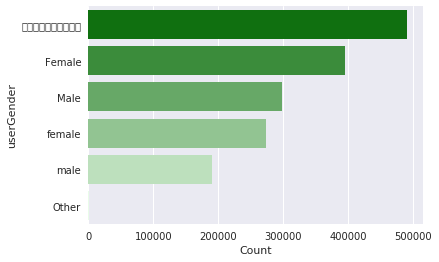

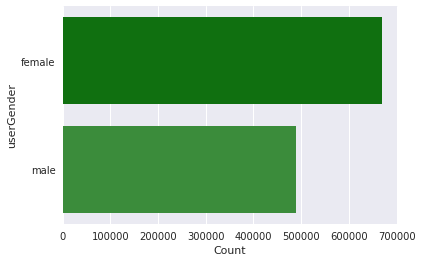

In [4]:
# gender
plot.figure()
userGender_before = data_original.groupby(by='userGender').size().sort_values(ascending=False)
sns.barplot(y=userGender_before.index, x=userGender_before, palette=(sns.light_palette("green",reverse=True)))
plot.xlabel('Count')
data.loc[:,'userGender'] = data.userGender.str.lower()
data.loc[:,'userGender'] = data.loc[(data.userGender=='female')|(data.userGender=='male'),'userGender']
plot.figure()
userGender_after = data.groupby(by='userGender').size().sort_values(ascending=False)
sns.barplot(y=userGender_after.index, x=userGender_after, palette=(sns.light_palette("green", reverse=True)))
plot.xlabel('Count')



Text(0,0.5,'Distribution')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


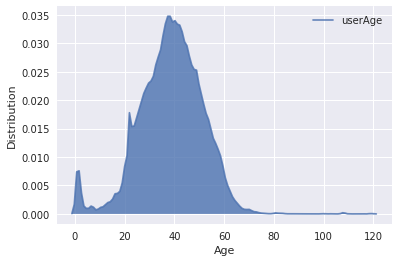

In [5]:
# age
plot.figure()
sns.kdeplot(data.loc[data.userAge.notnull(), 'userAge'], shade = True, alpha = 0.8)
plot.xlabel('Age')
plot.ylabel('Distribution')

Text(0,0.5,'Distribution')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


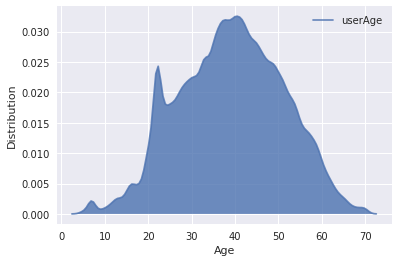

In [12]:
# filer out rows with none values from age and gender
data = data.loc[(~data.userGender.isnull()) & (~data.userAge.isnull()),:]
data = data.loc[(data.userAge >= 5) & (data.userAge <= 70),:]
plot.figure()
sns.kdeplot(data.loc[data.userAge.notnull(), 'userAge'], shade = True, alpha = 0.8)
plot.xlabel('Age')
plot.ylabel('Distribution')

Text(0.5,1,'user age binned')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


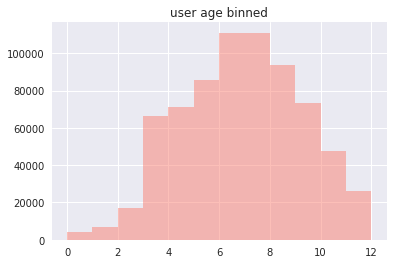

In [14]:
# bin user age
plot.figure()
data['userAgeBins'] = ((1+data.userAge)/5 ).apply(math.ceil)-2
plot.hist(data.userAgeBins,bins = range(0,13), alpha = 0.5, color='salmon')
plot.title('user age binned')


No handles with labels found to put in legend.


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


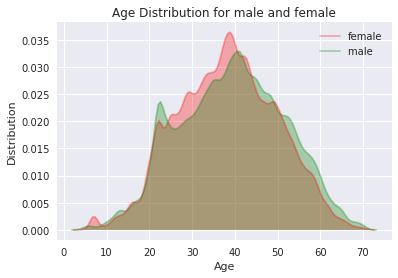

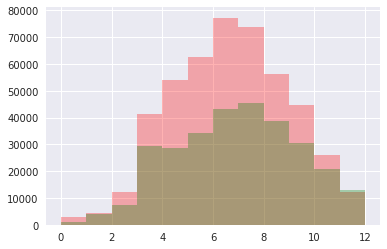

In [100]:
plot.figure()
fage = data.loc[data.userGender=='female','userAge']
mage = data.loc[data.userGender=='male','userAge']
sns.kdeplot(fage,label='female', shade = True, alpha = 0.3, color ='red')
sns.kdeplot(mage, label = 'male ',shade = True, alpha = 0.3, color = 'green')
plot.title('Age Distribution for male and female')
plot.xlabel('Age')
plot.ylabel('Distribution')


plot.figure()
fage = data.loc[data.userGender=='female','userAgeBins']
mage = data.loc[data.userGender=='male','userAgeBins']
plot.hist(fage, bins=range(0,13),alpha = 0.3, color ='red')
plot.hist(mage,bins=range(0,13), alpha = 0.3, color ='green')


In [64]:
data.replace({'userGender':{
  'female':0,
  'male':1
}}, inplace = True)

In [65]:

# data.userAge = data.userAge.astype('int')
#plot.figure()
#sns.kdeplot(data.userAge, data.userGender)

In [ ]:
#source
plot.figure()
source_before = data_original.groupby(by='source').size().sort_values(ascending=False)
sns.barplot(y=source_before.index, x=source_before, palette=(sns.light_palette("green",reverse=True)))
plot.xlabel('Count')

data.loc[data.source.str.contains('facebook'),'source'] = 'facebook' #data has inconsistent value such as 'facebook','facebook.com'
data.loc[data.source.str.contains('google'),'source'] = 'google'
data.loc[data.source.str.contains('sanook'),'source'] = 'sanook'
data.loc[data.source.str.contains('direct'),'source'] = 'direct'
data.loc[(data.source != 'facebook') &
         (data.source != 'google') &
         (data.source != 'sanook') &
         (data.source !='direct'),'source'] = 'other'
plot.figure()
source_after = data.groupby(by='source').size().sort_values(ascending=False)
sns.barplot(y=source_after.index, x=source_after, palette=(sns.light_palette("green", reverse=True)))
plot.xlabel('Count')

In [ ]:
#browser
plot.figure()
browser_before = data_original.groupby(by='browser').size().sort_values(ascending=False)
sns.barplot(y=browser_before.index, x=browser_before, palette=sns.light_palette('navy',reverse=True) )
plot.xlabel('Count')

data.loc[(data.browser != 'Chrome') &
         (data.browser != 'Safari') &
         (data.browser != 'Firefox') &
         (data.browser != 'Samsung Internet') &
         (data.browser != 'Android Webview') &
         (data.browser != 'Edge') &
         (data.browser !='Internet Explorer'),'browser'] = 'other'

plot.figure()
browser_after = data.groupby(by='browser').size().sort_values(ascending=False)
sns.barplot(y=browser_after.index, x=browser_after, palette=sns.light_palette('navy',reverse=True) )
plot.xlabel('Count')

In [ ]:
#language
plot.figure(figsize=(4,16))
language_before = data_original.groupby(by='language').size().sort_values(ascending=False)
sns.barplot(y=language_before.index, x=language_before, palette=sns.cubehelix_palette(8)  )
plot.xlabel('Count')


data.loc[data.language.str.contains('en'),'language'] = 'en'  #data has inconsistent values e.g. 'en','en-en','en-bg'
data.loc[data.language.str.contains('th'),'language'] = 'th'
data.language.str.contains('en|th')
data.loc[(data.language!='th') & 
         (data.language!='en'),'language'] = 'other'
plot.figure()
language_after = data.groupby(by='language').size().sort_values(ascending=False)
sns.barplot(y=language_after.index, x=language_after, palette=sns.cubehelix_palette(8) )
plot.xlabel('Count')


In [ ]:
#operatingSystem
plot.figure()
operatingSystem_before = data_original.groupby(by='operatingSystem').size().sort_values(ascending=False)
sns.barplot(y=operatingSystem_before.index, x=operatingSystem_before, palette=(sns.light_palette("orange",reverse=True)))
plot.xlabel('Count')

data.loc[(data.operatingSystem != 'Windows') &
         (data.operatingSystem != 'Android') &
         (data.operatingSystem != 'Macintosh') &
         (data.operatingSystem !='iOS'),'operatingSystem'] = 'other'

plot.figure()
operatingSystem_after = data.groupby(by='operatingSystem').size().sort_values(ascending=False)
sns.barplot(y=operatingSystem_after.index, x=operatingSystem_after, palette=(sns.light_palette("orange", reverse=True)))
plot.xlabel('Count')

In [ ]:
#deviceCategory
plot.figure()
operatingSystem_before = data_original.groupby(by='deviceCategory').size().sort_values(ascending=False)
sns.barplot(y=operatingSystem_before.index, x=operatingSystem_before, palette=(sns.light_palette("indigo",reverse=True)))
plot.xlabel('Count')


In [69]:
data.columns

Index(['fullVisitorId', 'VisitingHour', 'VisitingDayOfWeek', 'source',
       'browser', 'operatingSystem', 'language', 'deviceCategory',
       'contentSource', 'contentCategory', 'userGender', 'userAge',
       'userAgeBins'],
      dtype='object')

/usr/local/envs/py3env/lib/python3.5/site-packages/seaborn/categorical.py:633: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data[hue_mask])
/usr/local/envs/py3env/lib/python3.5/site-packages/seaborn/categorical.py:928: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data[hue_mask])
/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


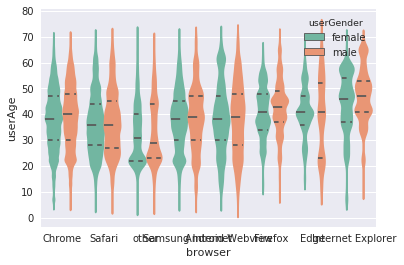

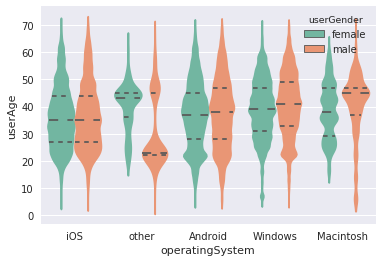

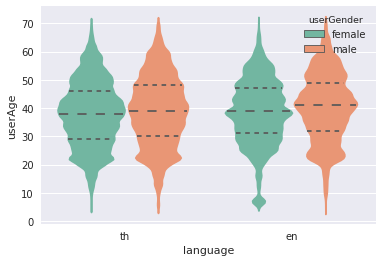

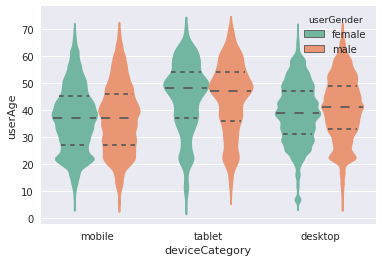

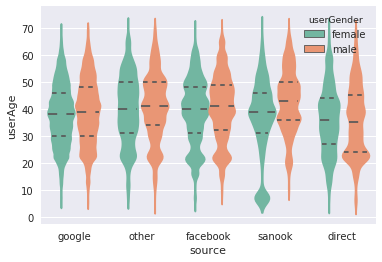

In [104]:
data.replace({'userGender':{
  0:'female',
  1:'male'
}}, inplace = True)

data.userAge = data.userAge.astype('int')
plot.figure() #figsize=(14,8)
sns.violinplot(x="browser", y="userAge", hue = 'userGender',palette="Set2",inner='quartile', split=False, data=data);
plot.figure()
sns.violinplot(x="operatingSystem", y="userAge", hue = 'userGender',palette="Set2",inner='quartile', split=False, data=data);
plot.figure()
sns.violinplot(x="language", y="userAge", hue = 'userGender',palette="Set2",inner='quartile', split=False, data=data);
plot.figure()
sns.violinplot(x="deviceCategory", y="userAge", hue = 'userGender',palette="Set2",inner='quartile', split=False, data=data);
plot.figure()
sns.violinplot(x="source", y="userAge", hue = 'userGender',palette="Set2",inner='quartile', split=False, data=data);

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


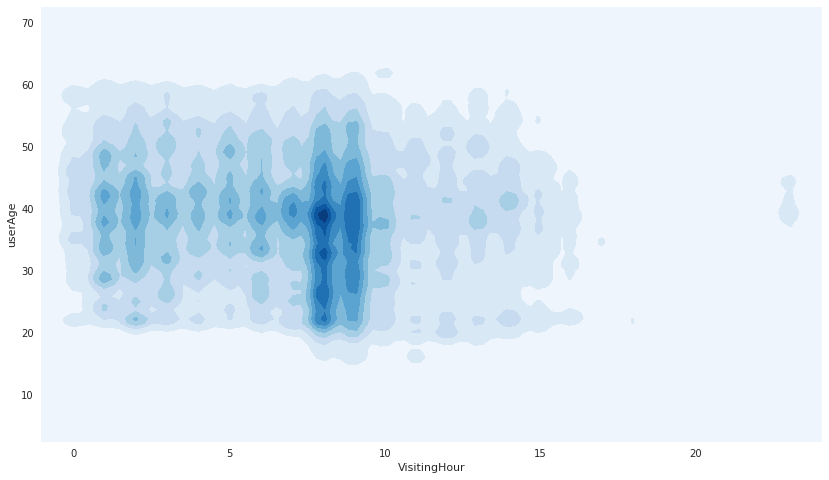

In [113]:
plot.figure(figsize=(14,8))
sns.kdeplot(data.visitingHour,data.userAge,cmap="Blues", shade=True)
#plot.xlim(6,11)